<h1>A3I Project - Choreography Planning by Decoupling A* Deterministic Search and Heuristic Computation</h1>
<h4 style="text-align: center">Authors: Lorenzo Balzani, Davide Bombardi</h4>
<p style="text-align: center">
    <a href="mailto:lorenzo.balzani@studio.unibo.it">lorenzo.balzani@studio.unibo.it</a> -
    <a href="mailto:davide.bombardi@studio.unibo.it">davide.bombardi@studio.unibo.it</a>
</p>


<h2>Abstract</h2>
<div class="abstract">
    <p>To Be Written (TBW)</p>
</div>

## Setup
Perform the following steps to setup the environment for running the code in this notebook:
1. Create a file named `secrets.env` in the root directory of the project and add the following lines:
    ```bash
    OPENAI_API_KEY=<your_openai_api_key>
    OPENAI_API_URL=https://api.openai.com
    ```
2. Setup the environment by launching the script `./setup_env.sh` in the terminal.
3. After activate it with `conda activate a3i`.
4. For installing the ipython kernel, please run `python -m ipykernel install --user --name=a3i`.

In [13]:
%%capture
!pip install load_dotenv langchain_openai loguru networkx matplotlib scipy

from dotenv import load_dotenv
import networkx as nx
from itertools import permutations
from itertools import product
import matplotlib.pyplot as plt
from langchain_openai import AzureChatOpenAI
from langchain_core.prompts import PromptTemplate
import random
from loguru import logger
import re
import heapq

load_dotenv("secrets.env")
seed = 42
random.seed(seed)

In [10]:
gpt_4o = AzureChatOpenAI(
    deployment_name="gpt-4o",
    temperature=0,
    verbose=True,
)

gpt_4o_mini = AzureChatOpenAI(
    deployment_name="gpt-4o-mini",
    temperature=0,
    verbose=True,
)

## Position Graph Creation

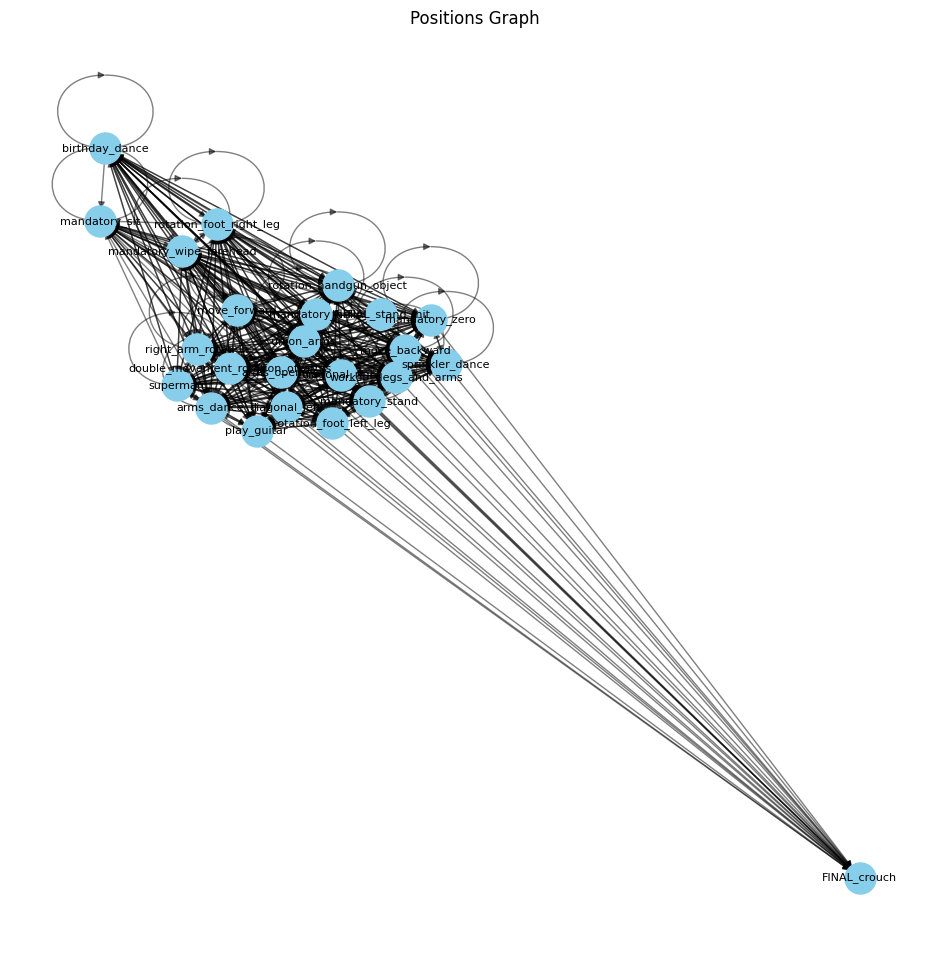

In [11]:
initial_state = 'INITIAL_stand_init'
final_state = 'FINAL_crouch'

# Define the list of nodes
nodes = {initial_state, 'rotation_handgun_object', 'right_arm_rotation', 'double_movement_rotation_of_arms',
         'arms_opening', 'union_arms', 'move_forward', 'move_backward', 'diagonal_left', 'diagonal_right',
         'rotation_foot_left_leg', 'rotation_foot_right_leg', 'play_guitar', 'arms_dance', 'birthday_dance',
         'sprinkler_dance', 'workout_legs_and_arms', 'superman', 'mandatory_sit', 'mandatory_wipe_forehead',
         'mandatory_hello', 'mandatory_stand', 'mandatory_zero', final_state}

# Define the exception nodes for which there are incompatible transitions
exception_nodes = {"mandatory_sit": {'diagonal_right', 'diagonal_left', 'rotation_foot_right_leg', 'rotation_foot_left_leg',
                                     final_state, 'move_backward', 'move_forward', 'play_guitar', 'arms_dance', 'birthday_dance',
                                     'sprinkler_dance', 'workout_legs_and_arms', 'superman'}
}


# Initialize the directed graph, since there are incompatible transitions between some nodes
G = nx.DiGraph()
G.add_nodes_from(nodes)

# Add edges between all pairs of nodes except the specified exceptions
for u, v in product(nodes, repeat=2):
    if u == final_state: # Skip adding edges from 'FINAL_crouch' to other nodes, since it is the final node
        continue
    if v == initial_state: # Skip adding edges to 'INITIAL_stand_init', since it is the initial node
        continue
    if u in exception_nodes and v in exception_nodes[u]: # Skip adding edges if the pair is in the exception list
        continue
    G.add_edge(u, v, weight=1)  # Add an edge with a cost of 1

# Visualize the graph
plt.figure(figsize=(12, 12))
pos = nx.spring_layout(G, k=0.15)
nx.draw_networkx_nodes(G, pos, node_size=500, node_color='skyblue')
nx.draw_networkx_edges(G, pos, width=1.0, alpha=0.5)
nx.draw_networkx_labels(G, pos, font_size=8, font_family='sans-serif')

plt.axis('off')
plt.title('Positions Graph')
plt.show()

## Graph Statistics

In [14]:
# 1. Number of nodes
num_nodes = G.number_of_nodes()
print(f"1. Number of nodes: {num_nodes}")

# 2. Number of edges
num_edges = G.number_of_edges()
print(f"2. Number of edges: {num_edges}")

# 3. Average in-degree and out-degree
in_degrees = G.in_degree()
out_degrees = G.out_degree()
avg_in_degree = sum(dict(in_degrees).values()) / num_nodes
avg_out_degree = sum(dict(out_degrees).values()) / num_nodes
print(f"3. Average in-degree: {avg_in_degree:.2f}\t--\tAverage out-degree: {avg_out_degree:.2f}")

# 4. Density of the graph
density = nx.density(G)
print(f"4. Graph density: {density:.4f}")

# 5. Is the graph strongly connected?
is_strongly_connected = nx.is_strongly_connected(G)
print(f"5. Is the graph strongly connected? {is_strongly_connected}")

# 6. Number of strongly connected components
num_scc = nx.number_strongly_connected_components(G)
print(f"6. Number of strongly connected components: {num_scc}")

# 7. Average clustering coefficient
# For DiGraph, we use the directed version of clustering coefficient
avg_clustering = nx.average_clustering(G)
print(f"7. Average clustering coefficient: {avg_clustering:.4f}")

# 8. Top 3 nodes by PageRank
pagerank = nx.pagerank(G)
top_3_pagerank = sorted(pagerank.items(), key=lambda x: x[1], reverse=True)[:3]
print("8. Top 3 nodes by PageRank:")
for node, pr in top_3_pagerank:
    print(f"  {node}: {pr:.4f}")

# 9. In-degree and out-degree of 'mandatory_sit'
in_degree_mandatory_sit = G.in_degree('mandatory_sit')
out_degree_mandatory_sit = G.out_degree('mandatory_sit')
print(f"9. 'mandatory_sit' in-degree: {in_degree_mandatory_sit}\t--\tout-degree: {out_degree_mandatory_sit}")

# 10. Average shortest path length (if the graph is strongly connected)
if is_strongly_connected:
    avg_shortest_path_length = nx.average_shortest_path_length(G)
    print(f"10. Average shortest path length: {avg_shortest_path_length:.4f}")
else:
    print("10. Graph is not strongly connected; average shortest path length not defined.")

# 11. Number of nodes with zero in-degree (sources)
zero_in_degree = [n for n, d in G.in_degree() if d == 0]
print(f"11. Number of nodes with zero in-degree (sources): {len(zero_in_degree)}")

# 12. Number of nodes with zero out-degree (sinks)
zero_out_degree = [n for n, d in G.out_degree() if d == 0]
print(f"12. Number of nodes with zero out-degree (sinks): {len(zero_out_degree)}")

# 13. Diameter of the graph (if strongly connected)
if is_strongly_connected:
    diameter = nx.diameter(G)
    print(f"13. Diameter of the graph: {diameter}")
else:
    print("13. Graph is not strongly connected; diameter not defined.")

# 14. Eccentricity of the initial state (if strongly connected)
if is_strongly_connected:
    eccentricity = nx.eccentricity(G, initial_state)
    print(f"14. Eccentricity of '{initial_state}': {eccentricity}")
else:
    print("14. Graph is not strongly connected; eccentricity not defined.")

1. Number of nodes: 24
2. Number of edges: 516
3. Average in-degree: 21.50	--	Average out-degree: 21.50
4. Graph density: 0.9348
5. Is the graph strongly connected? False
6. Number of strongly connected components: 3
7. Average clustering coefficient: 0.9365
8. Top 3 nodes by PageRank:
  mandatory_wipe_forehead: 0.0453
  right_arm_rotation: 0.0453
  double_movement_rotation_of_arms: 0.0453
9. 'mandatory_sit' in-degree: 23	--	out-degree: 10
10. Graph is not strongly connected; average shortest path length not defined.
11. Number of nodes with zero in-degree (sources): 1
12. Number of nodes with zero out-degree (sinks): 1
13. Graph is not strongly connected; diameter not defined.
14. Graph is not strongly connected; eccentricity not defined.


## Graph Waypoints definition

In [15]:
# Define a prompt template for getting waypoints
waypoint_prompt = PromptTemplate(
    input_variables=['initial_state', 'final_state', 'positions'],
    template="""
    Given the initial state {initial_state} and the final state {final_state}, output a **strictly comma-separated list** of positions from the available ones that create a very cool, elegant and creative movement sequence. Include initial and final state. Do not include any other text in the output, and format the list exactly as: `position1, position2, position3`.

    # POSITIONS
    {positions}
    """
)

# Create an LLMChain for waypoints
waypoint_chain = waypoint_prompt | gpt_4o

# Define the available positions as the union of all the nodes except the initial and final states
available_positions = list(nodes - {initial_state, final_state})
random.shuffle(available_positions)

# Run the chain
result = waypoint_chain.invoke({"initial_state": initial_state, "final_state": final_state, "positions": available_positions})

# Extract the comma-separated list using regex
waypoints = re.findall(r'\b\w+(?:, \w+)*\b', result.content)
print(f"Waypoints sequence: {waypoints}")

Waypoints sequence: ['INITIAL_stand_init', 'mandatory_stand', 'diagonal_left', 'superman', 'rotation_foot_right_leg', 'arms_opening', 'FINAL_crouch']


## OLD1 - A* Search Algorithm between waypoints
### Herustic definition
Should receive:
1. Current state, i.e. made of the sequence of positions already visited + the current position
2. The next waypoint to reach
3. max_coolness_score

Evaluate the current state with respect to the goal of reaching the next waypoint in the coolest way possible.

In [ ]:
heuristic_cache = {}
gpt_4o_mini_costs = {"prompt": 0.14311/1e6, "completion": 0.5725/1e6}
gpt_4o_costs = {"prompt": 2.31514/1e6, "completion": 9.2606/1e6}

def estimate_coolness_to_goal_llm(dance_sequence, max_coolness_score=100):
    """
    Estimate the coolness of transitioning from the current node to the goal node using the LLM.

    Parameters:
    - dance_sequence (List[str]): The sequence of dance moves leading up to the current node.
    - max_coolness_score (float, Optional): The maximum possible coolness score. Defaults to 100.

    Returns:
    - coolness_score (float): The estimated coolness score for transitioning to the goal node.
    - coolness_estimation (float): The estimated maximum possible coolness score for the entire sequence.
    - total_cost (float): The total cost of invoking the LLM.
    """

    dance_sequence = tuple(dance_sequence)

    # Check if the coolness value is already computed and cached
    if dance_sequence in heuristic_cache:
        return heuristic_cache[dance_sequence], 0

    # Prepare the inputs for the LLM prompt
    prompt_inputs = {
        'dance_sequence': str(list(dance_sequence)),
        'max_coolness_score': max_coolness_score
    }

    # Run the chain, extract and process the response
    try:
        # Call the LLM to get the coolness score
        response = (heuristic_prompt | gpt_4o_mini).invoke(prompt_inputs)
        cost = response.response_metadata["token_usage"]
        total_cost = cost["prompt_tokens"] * gpt_4o_mini_costs["prompt"] + cost["completion_tokens"] * gpt_4o_mini_costs["completion"]

        coolness_estimation = float(response.content.strip())

        # Force the coolness from 0 to max_coolness_score
        coolness_estimation = max(0, int(coolness_estimation))
        coolness_estimation = min(coolness_estimation, max_coolness_score)

        # Store the coolness score in the cache
        heuristic_cache[dance_sequence] = coolness_estimation

        return coolness_estimation, total_cost
    except ValueError as e:
        raise ValueError(f"Invalid response from the LLM: {e}")

## OLD2 - Definizione delle funzioni di A*
Se ho capito bene, normalmente 𝓰(P)+𝒽(P) da un valore che rappresenta una stima del punteggio della miglior soluzione ottenibile partendo da P. In particolare 𝓰(P) è il punteggio accumulato da P fino a questo punto, mentre 𝒽(P) è una stima del punteggio migliore ottenibile partendo da P.
Nel nostro caso il punteggio che vogliamo massimizzare è la coolness, che però può essere calcolata solo da un llm. Di conseguenza sia 𝓰(P) che 𝒽(P) vanno trovate usando un llm (???)

### 1. Coolness 𝓰 di un percorso:
Si potrebbe chiedere al llm quanto è buona la soluzione P con un punteggio cool(P) ∈ ]0,100[. Per indirizzare verso il completamento degli obbiettivi, si potrebbe tener conto degli obiettivi raggiunti.

La funzione 𝓰 potrebbe essere 𝓰(P):

𝓰(P) = -cool(P)⋅(#obiettivi raggiunti / #Obiettivi totali)

Così risulterà con un punteggio più alto (col meno = basso dato che A* cerca di ridurre il cossto) il percorso più cool fino a quel momento e a parità di coolness quello con più obiettivi raggiunti

### 2. Euristica 𝒽 di un percorso:
Nel normale algoritmo A*, 𝓰(P)+𝒽(P) da una stima del costo del miglior percorso che si può creare preseguendo con P. Nel nostro caso quindi si potrebbe chiedere all'llm che punteggio potrebbe ottenere una coreografia che parte da P e poi prosegue nel modo ottimale? Forse è una richiesta un po' troppo astratta. Se questo punteggio è cool_estimation(P), avremo che

𝒽(P) = - cool_estimation(P) + cool(P)

N.B. cool(P) e cool_estimation(P) potrebbero essere chieste anche insieme all'llm con un unico prompt.

### 3. Vicinanza al prossimo target:
Deve spingere A* a scegliere la strada che porta al target successivo:
𝓽(P) = lunghezza per arrivare al target

## Priorità di un percorso:
Non so se ha senso valutare dei pesi. Forse no. Nel caso sarebbe:

Pr(P)  =  α ⋅ 𝓰(P)  +  β ⋅ 𝒽(P)  +  γ ⋅ 𝓽(P)

In [ ]:
def g_function(sequence, mandatory_positions, intermediate_positions, n_intermediate_positions, cool):
    n_mandatory_check = len({move for move in sequence if move in mandatory_positions})
    n_intermediate_check = len({move for move in sequence if move in intermediate_positions})
    achieved_goals = n_mandatory_check + n_intermediate_check
    goals = len(mandatory_positions) + n_intermediate_positions

    # Coolness must be proportional to the ratio of achieved goals to total goals (i.e., both mandatory and intermediate goals)
    return_value = - cool * achieved_goals / goals
    print(f"g-function for sequence {sequence}: cool={cool}, achieved_goals={achieved_goals}, goals={goals}, return={return_value}")
    return return_value


def h_function(cool, cool_estimation):
  return - cool_estimation + cool

def t_function(sequence, current_target, shortest_path):
    """Dovrebbe indicare quante mosse mancano a poter aggiungere il target. 0 se si può aggiungere subito dopo.
  Si potrebbe usare nx.shortest_path_length(graph, sequence[-1], current_target)
  Oppure, dato che non dipende da il percorso fatto ma solo da due nodi, si potrebbe calcolare per ogni coppia di nodi con nx.all_pairs_shortest_path_length(graph) A PRIORI e in questa funzione
  si consulta solo la mega matrice/dizionario"""
    return shortest_path[sequence[-1]][current_target]


In [ ]:
def LLM_AStar_4Choreography(graph, start, goal, targets, mandatory_positions, intermediate_positions, n_intermediate_postions, g_function, h_function, t_function):
    """
    Arguments:
    ----------
        graph
        start
        goal
        targets
        mandatory_positions
        intermediate_positions
        n_intermediate_positions
        g_function
        h_function
        t_function

    Returns:
    -------
        path
    """
    open_set = []
    total_cost = 0
    total_calls = 0
    heapq.heappush(open_set, (0, [start], 1))  # (estimated coolness of complete path, uncompleted path, index of current target)
    shortest_path = dict(nx.all_pairs_shortest_path_length(graph))

    while open_set:
        _, current_sequence, current_target_index = heapq.heappop(open_set)
        current_target = targets[current_target_index]
        current_node = current_sequence[-1]

        if current_node == goal:
            return current_sequence
        elif current_node == current_target:
            if current_target_index < len(targets) - 1:
                current_target_index += 1
                current_target = targets[current_target_index]

        n_mandatory_check = len({move for move in current_sequence if move in mandatory_positions})
        n_intermediate_check = len({move for move in current_sequence if move in intermediate_positions})

        all_goals_achieved = n_mandatory_check == len(mandatory_positions) and n_intermediate_check == n_intermediate_postions

        for move in graph.neighbors(current_node):
            if all_goals_achieved or move != goal:
                new_sequence = current_sequence + [move]

                '''llm'''
                cool_estimation, heuristic_cost = estimate_coolness_to_goal_llm(new_sequence)
                total_cost += heuristic_cost
                total_calls += 1

                estimated_coolness = g_function(new_sequence, mandatory_positions, intermediate_positions, n_intermediate_postions, cool_estimation)
                if move != current_target:
                    estimated_coolness += t_function(new_sequence, current_target, shortest_path)
                heapq.heappush(open_set, (estimated_coolness, new_sequence, current_target_index))
        print(f"Current sequence: {current_sequence}")
        print(f"Current cost: {total_cost:.6f}€ - Total calls: {total_calls}\n")
    return None


In [ ]:
mandatory_positions = {'mandatory_sit', 'mandatory_wipe_forehead', 'mandatory_hello', 'mandatory_stand', 'mandatory_zero'}
intermediate_positions = list(nodes - {initial_state, final_state} - mandatory_positions)

LLM_AStar_4Choreography(graph=G, start=initial_state, goal=final_state, targets=waypoints,
                        mandatory_positions=mandatory_positions, intermediate_positions=intermediate_positions,
                        n_intermediate_postions=len(mandatory_positions), g_function=g_function, h_function=h_function, t_function=t_function)

## SOLUTION3 - Old one presented to Allegra on 08/01/2025

Per ogni elemento di open_set: due utilizzi dell'llm (invece che 1+num_neighbors)

###Primo utilizzo (`g_llm`):
Gli passo una sequenza `sequence` a cui aggiungo forzatamente la posa finale (anche se non dura max_duration secondi e non ha i requisiti) e gli chiedo di valutarla con uno score `coolness_estimation` (da 0 a 10), considerando che 10 è il voto per la miglior coreografia possibile tra quelle con lunghezza = `len(sequence)` e 0 è il voto della coreografia più brutta possibile tra quelle  con lunghezza = `len(sequence)`. In più gli chiedo una stima in secondi `choreo_duration` della durata della coreografia.

L'output dell'llm servirà a `g_function` per calcolare il punteggio della coreografia attuale, che contribuirà al punteggio totale (i.e. `g_function+h_function`) pesata con `choreo_duration`.

###Secondo utilizzo (`h_llm`):

Gli passo una sequenza `sequence` e un elenco di mosse possibili `neighbors_list`. Lui deve assegnare ad ogni mossa un punteggio da 0 a 10 considerando che quelle valutate con punteggio più alto saranno considerate per proseguire `sequence`.

L'output è una lista di scores. Data una possibile mossa e il suo score `h_function` dovrebbe restiture una proiezione di quanto può aggiungere al toatle il proseguimento della coreografia con la mossa scelta. Lo fa pesando lo score della mossa con i secondi rimanenti (max_duration-`choreo_duration`)

### Idee implementate:
- Meno chiamate all'llm
- Punteggio in decimi e non 100esimi, tanto in 100esimi dava solo multipli di 5
- Il numero di constraint soddisfatti viene aggiunto allo score (i.e. `g_function+h_function`) in modo da favorire i percorsi con più constraint soddisfatti
- La distanza dal target viene tolta dallo score (i.e. `g_function+h_function`) in modo da sfavorire le mosse più distanti dal target.

### Possibili criticità (speriamo di no):
- Output di h non ha la forma giusta. Potrebbe aver senso splittare i vicini in 2 o 3 e usare h_llm rispettivamente 2 o 3 volte per avere una lista più breve di posizioni da valutare
- La coolness avrà un punteggio massimo di `max_duration*10` quindi è possibile che aggiungere il numero di constraint soddisfatti non abbia molto potere nel direzionare la soluzione in verso un completamento dei constraint. Si potrebbe pesare di più il numero di constraint soddisfatti (moltiplicandolo per una costante da decidere)
- Stessa cosa del punto prima (ma ancora più accentuata) per il target. Si potrebbe da subito moltiplicare per 10 il contributo della `t_function`.
- Score totale (i.e. `g_function+h_function` + constraint - distanza target) non indicativo della bontà di una soluzione. Rip.

In [ ]:
g_prompt = PromptTemplate(
    input_variables=['len_sequence', 'dance_sequence'],
    template="""
Role and Context: You are an expert robotic dance choreographer. Your task is to evaluate a complete choreography for a NAO robot, represented as a sequence of {len_sequence} dance moves or positions. You must provide two numerical outputs: the coolness score of the choreography and its total time duration in seconds.

Task:

Evaluate the given dance sequence based on the following criteria:

1. **Coolness Score:**
   - Rate the choreography on a scale from 0 to 10.
   - Consider how well transitions flow between moves, the creativity, aesthetics, and audience appeal.
   - The best possible sequence with length {len_sequence} has a score of 10, and the worst has a score of 0.

2. **Duration:**
   - Provide the total time duration of the choreography in seconds.

Output Format:
Provide ONLY two numerical values in the format:
`coolness_score,choreography_duration`

Do not include any text, commentary, or explanation.

Input:
Dance Sequence: {dance_sequence}
""")

h_prompt = PromptTemplate(
    input_variables=['n_neighbors', 'neighbors_list', 'dance_sequence', 'duration'],
    template="""
    Role and Context: You are an expert robotic dance choreographer. Your task is to improve an incomplete choreography for a NAO robot. You will be provided with:
    1. An incomplete list of dance moves or positions (referred to as the current choreography).
    2. A list of possible moves to evaluate for inclusion in the choreography (referred to as the possible moves). Your job is to assign a coolness score to each possible move based on how well it improves the choreography. The highest-rated moves will be considered for inclusion.

Task: Provide {n_neighbors} numerical scores between 0 and 10, one for each possible move, in the exact order they are listed. The first score corresponds to the first move in the list, the second score to the second move, and so on.

Important Guidelines:
- Scoring Criteria: Moves should be evaluated based on how much they improve the choreography.
- Duration: The choreography should have a total duration of {duration} seconds.
- Consistency: Rate moves consistently and fairly. Similar moves should receive similar scores.
- Diversity: Consider the variety, creativity, and aesthetic appeal of the moves. Give lower scores to moves that are are repetitive.
- Output Format: Provide ONLY the {n_neighbors} scores in the format: coolness_score_first_move,coolness_score_second_move,...,coolness_score_{n_neighbors}-th_move. Do not include any explanations, text, or comments.

Input:
Current choreography: {dance_sequence}
Possible Moves: {neighbors_list}
""")


In [ ]:
heuristic_cache = {'g': {}, 'h': {}}
gpt_4o_mini_costs = {"prompt": 0.14311/1e6, "completion": 0.5725/1e6}
gpt_4o_costs = {"prompt": 2.31514/1e6, "completion": 9.2606/1e6}
#max_duration = 30 # seconds

def g_llm(dance_sequence):
    """
    Evaluate a complete dance_sequence using the LLM.

    Parameters:
    - dance_sequence (List[str]): The sequence of dance moves.

    Output:
    - coolness_score (float): The estimated coolness score for the dance_sequence.
    """
    # Remove INITIAL_stand_init from the dance_sequence
    if dance_sequence[0] == 'INITIAL_stand_init':
        dance_sequence = dance_sequence[1:]

    dance_sequence = tuple(dance_sequence)

    # Check if the coolness value is already computed and cached
    if dance_sequence in heuristic_cache["g"]:
        return *heuristic_cache["g"][dance_sequence], 0

    # Prepare the inputs for the LLM prompt
    prompt_inputs = {
        'len_sequence': len(dance_sequence),
        'dance_sequence': str(list(dance_sequence))
    }

    # Run the chain, extract and process the response
    try:
        # Call the LLM to get the coolness score
        response = (g_prompt | gpt_4o_mini).invoke(prompt_inputs)
        cost = response.response_metadata["token_usage"]
        total_cost = cost["prompt_tokens"] * gpt_4o_mini_costs["prompt"] + cost["completion_tokens"] * gpt_4o_mini_costs["completion"]

        coolness_estimation, choreo_duration = response.content.strip().split(",")

        # Force the coolness from 0 to max_coolness_score
        coolness_estimation = max(0.0, float(coolness_estimation))
        coolness_estimation = min(coolness_estimation, 10.0)

        # Store the coolness score in the cache
        heuristic_cache["g"][dance_sequence] = (coolness_estimation, int(choreo_duration))

        return *heuristic_cache["g"][dance_sequence], total_cost
    except ValueError as e:
        raise ValueError(f"Invalid response from the g_LLM: {e}")

def h_llm(neighbors_list, dance_sequence):
    """
    Give one score for each move in a list of moves neighbors_list that could follow the current dance_sequence, using the LLM.

    Parameters:
    - neighbors_list (List[str]): The list of possible moves to evaluate.
    - dance_sequence (List[str]): The sequence of dance moves.

    Output:
    - coolness_scores (List[float]): The estimated coolness scores for the possible moves.
    """
    dance_sequence = tuple(dance_sequence)

    # Check if the coolness value is already computed and cached
    if dance_sequence in heuristic_cache:
        return heuristic_cache["h"][dance_sequence], 0

    # Prepare the inputs for the LLM prompt
    prompt_inputs = {
        'n_neighbors' : len(neighbors_list),
        'neighbors_list': str(neighbors_list),
        'dance_sequence' : str(list(dance_sequence)),
        'duration': max_duration
    }

    # Run the chain, extract and process the response
    try:
        # Call the LLM to get the coolness score
        response = (h_prompt | gpt_4o_mini).invoke(prompt_inputs)
        cost = response.response_metadata["token_usage"]
        total_cost = cost["prompt_tokens"] * gpt_4o_mini_costs["prompt"] + cost["completion_tokens"] * gpt_4o_mini_costs["completion"]
        coolness_estimations = response.content.strip().split(",")

        if len(neighbors_list) != len(coolness_estimations):
            raise ValueError("The number of coolness estimations does not match the number of neighbors")

        for i in range(len(coolness_estimations)):
            coolness_estimations[i] = max(0.0, float(coolness_estimations[i]))
            coolness_estimations[i] = min(coolness_estimations[i], 10.0)

        # Store the coolness score in the cache
        heuristic_cache["h"][dance_sequence] = coolness_estimations

        return coolness_estimations, total_cost
    except ValueError as e:
        raise ValueError(f"Invalid response from the h_LLM: {e}")

In [ ]:
achieved_goals_weight = 3

def g_function(cool, choreo_duration):
    """
    Compute the component of the total score that is due to the already defined choreography + add the number of satisfied constraints
    """
    return_value = - cool * min(choreo_duration, max_duration)

    #print(f"g-function for current sequence return={return_value}")
    return return_value

def h_function(cool_estimation, choreo_duration):
    """
    Compute the component of the total score that is due to a prediction on the final choreography based on the last move added + add achieved_goals_weight if the last added move satisfies a constraint
    """
    return_value = - cool_estimation * (max_duration-choreo_duration)

    #print(f"h-function for sequence cool_estimation={cool_estimation}, return={return_value}")
    return return_value


def t_function(sequence, current_target, shortest_path, shortest_path_inverted):
    """Dovrebbe indicare quante mosse mancano a poter aggiungere il target. 0 se si può aggiungere subito dopo.
  Si potrebbe usare nx.shortest_path_length(graph, sequence[-1], current_target)
  Oppure, dato che non dipende da il percorso fatto ma solo da due nodi, si potrebbe calcolare per ogni coppia di nodi con nx.all_pairs_shortest_path_length(graph) A PRIORI e in questa funzione
  si consulta solo la mega matrice/dizionario"""

    """
    We divide the shortest path by the length of the furthest node to the current_target. It's bounded between 0 and 1. The lowest the returned value, the better.
    """
    current_node = sequence[-1]
    if current_node == final_state:
        return 3

    return_value = shortest_path[current_node][current_target] / (max(shortest_path_inverted[current_target].values()))

    #print(f"t-function for sequence {sequence} and target {current_target} return={return_value}")
    return return_value

###First Heuristic

In [ ]:
def f_function(coolness_value, cool_estimation, choreo_duration, new_sequence, current_target, shortest_path, shortest_path_inverted,
               max_duration, n_intermediate_postions, choreo_duration_weight):

    estimated_coolness = g_function(coolness_value, choreo_duration) + h_function(cool_estimation, choreo_duration)

    t_function(new_sequence, current_target, shortest_path, shortest_path_inverted) * 10 * max_duration * 0.4

    adjusted_coro_duration = asymetric_distribution(choreo_duration)

    (estimated_coolness - adjusted_coro_duration * choreo_duration * choreo_duration_weight) - compute_targets_count(new_sequence, n_intermediate_postions) * 10 * max_duration

In [ ]:
def f_function_2(coolness_value, cool_estimation, choreo_duration, new_sequence, current_target, shortest_path, shortest_path_inverted,
               n_intermediate_postions, choreo_duration_weight, max_duration = 120, max_coolness_value = 5):

    #In teoria estimated_coolness va da 0 a 1
    estimated_coolness = g_function(coolness_value, choreo_duration) / (max_duration * max_coolness_value) + h_function(cool_estimation, choreo_duration) / (max_duration * max_coolness_value)

    distance_from_target = t_function(new_sequence, current_target, shortest_path, shortest_path_inverted) * 10 * max_duration * 0.4

    adjusted_coro_duration = asymetric_distribution(choreo_duration)

    (estimated_coolness - adjusted_coro_duration * choreo_duration * choreo_duration_weight) - compute_targets_count(new_sequence, n_intermediate_postions) * 10 * max_duration

In [ ]:
def asymetric_distribution(x, mu=max_duration, sigma=5, alpha=-0.1):
    """
    Behave like a normal distribution for x < mu and like a normal distribution + exp for x > mu

    Things near the mu are normal, way higher are penalized more.
    """
    if x <= mu:
        return np.exp(- (x - mu)**2 / (2 * sigma**2))
        # Funzione gaussiana normale
    else:
        return np.exp(- (x - mu)**2 / (2 * sigma**2)) * np.exp(alpha * (x - mu)) # Penalizzazione maggiore per x > mu

In [ ]:
from time import time
from collections import defaultdict
import numpy as np

debug = False

def compute_targets_count(sequence, n_intermediate_positions):
    # Achieved goals IF we choose this move
    n_mandatory_check = len({move for move in sequence if move in mandatory_positions})
    n_intermediate_check = min(len({move for move in sequence if move in intermediate_positions}), n_intermediate_positions)
    return (1 + n_mandatory_check + n_intermediate_check)/(1 + len(mandatory_positions) + len(intermediate_positions))

def adjust_estimated_coolness(estimated_coolness, max_duration, choreo_duration, choreo_duration_weight, sequence, n_intermediate_postions):
    """
    We subtract the duration of the choreography from the max_duration to give a penalty to shorter choreographies.
    coolness_value, max_duration, choreo_duration, choreo_duration_weight, current_sequence, n_intermediate_positions
    """
    adjusted_coro_duration = asymetric_distribution(choreo_duration)

    return (estimated_coolness - adjusted_coro_duration * choreo_duration * choreo_duration_weight) - compute_targets_count(sequence, n_intermediate_postions) * 10 * max_duration

def LLM_AStar_4Choreography(graph, start, goal, targets, mandatory_positions, intermediate_positions, n_intermediate_postions, g_function, h_function, t_function, timeout=30, choreo_duration_weight=1):
    open_set = []
    candidate_return = []
    total_cost = 0
    total_calls = 0
    heapq.heappush(open_set, (0, [start], 1))  # (estimated coolness of complete path, uncompleted path, index of current target)
    shortest_path = dict(nx.all_pairs_shortest_path_length(graph))

    # Used in t-functon
    shortest_path_inverted = defaultdict(dict)
    for source, target_dict in shortest_path.items():
        for target, length in target_dict.items():
            shortest_path_inverted[target][source] = length

    # Run the A* algorithm
    time_now = time()
    while open_set:
        elapsed_time = time()-time_now
        if candidate_return and elapsed_time > timeout:
            candidate_return.sort(key=lambda x: x[0], reverse=True)
            if debug:
                print(f"Timeout reached. Returning best candidate so far (score: {candidate_return[0][1]})")
            return candidate_return[0], total_cost, total_calls, elapsed_time
        _, current_sequence, current_target_index = heapq.heappop(open_set)
        current_target = targets[current_target_index]
        current_node = current_sequence[-1]

        if current_node == goal:
            return current_sequence, total_cost, total_calls, elapsed_time
        elif current_node == current_target:
            if current_target_index < len(targets) - 1:
                current_target_index += 1
                current_target = targets[current_target_index]

        n_mandatory_check = len({move for move in current_sequence if move in mandatory_positions})
        n_intermediate_check = len({move for move in current_sequence if move in intermediate_positions})

        all_goals_achieved = n_mandatory_check == len(mandatory_positions) and n_intermediate_check >= n_intermediate_postions

        #Valuta la current_sequence
        coolness_value, choreo_duration, heuristic_cost = g_llm(current_sequence)
        total_cost += heuristic_cost
        total_calls += 1

        if choreo_duration >= max_duration: #and all_goals_achieved: # Push to heap IFF the max_duration is reached. Hopefully will be returned at next iteration
            converted_coolness_value = g_function(coolness_value, choreo_duration) # we don't need any h-function given we don't have any neighbors thus any inference to make
            adjusted_estimated_coolness = adjust_estimated_coolness(converted_coolness_value, max_duration, choreo_duration, choreo_duration_weight, current_sequence, n_intermediate_postions)
            candidate_return.append((adjusted_estimated_coolness, current_sequence + [goal]))
            if debug:
                print(f"Found a candidate with score {coolness_value} and duration {choreo_duration}")
            heapq.heappush(open_set, (*candidate_return[-1], current_target_index))
        else:
            neighbors_list = list(graph.neighbors(current_node))
            if goal in neighbors_list and not all_goals_achieved:
                neighbors_list.remove(goal)

            # Check the neighbors
            coolness_estimations, heuristic_cost = h_llm(neighbors_list, current_sequence)

            total_cost += heuristic_cost
            total_calls += 1

            for move, cool_estimation in zip(neighbors_list, coolness_estimations):
                new_sequence = current_sequence + [move]
                # Qui calcolerei l'estimated_coolness con una funzione singola
                estimated_coolness = g_function(coolness_value, choreo_duration) + h_function(cool_estimation, choreo_duration)
                estimated_coolness += t_function(new_sequence, current_target, shortest_path, shortest_path_inverted) * 10 * max_duration * 0.4
                adjusted_estimated_coolness = adjust_estimated_coolness(estimated_coolness, max_duration, choreo_duration, choreo_duration_weight, current_sequence, n_intermediate_postions)
                heapq.heappush(open_set, (adjusted_estimated_coolness, new_sequence, current_target_index))
        if debug:
            print(f"CURRENT sequence: {current_sequence} - Total duration: {choreo_duration}s - Coolness: {coolness_value} - All goals achieved: {all_goals_achieved}")
            print(f"CURRENT cost: {total_cost:.6f}€ - Total calls: {total_calls}\n")

In [ ]:
mandatory_positions = {'mandatory_sit', 'mandatory_wipe_forehead', 'mandatory_hello', 'mandatory_stand', 'mandatory_zero'}
intermediate_positions = list(nodes - {initial_state, final_state} - mandatory_positions)

choreography, cost, n_calls, elapsed_time = LLM_AStar_4Choreography(graph=G, start=initial_state, goal=final_state, targets=waypoints,
                                                                    mandatory_positions=mandatory_positions, intermediate_positions=intermediate_positions,
                                                                    n_intermediate_postions=2, g_function=g_function, h_function=h_function, t_function=t_function)
print(f"Choreography: {choreography}\nCost: {cost:.5f}€\nNumber of calls to LLM: {n_calls}\nElapsed time: {elapsed_time:.2f}s")

In [ ]:
waypoints

## SOLUTION4 - Final A*

In [135]:
moves_duration_prompt = PromptTemplate(
    input_variables=["moves"],
    template="""
    You are a robotics expert analyzing the motion efficiency of a NAO robot. Below is a list of moves the robot will perform. For each move, provide the estimated duration in seconds based on typical execution times for similar robotic actions:

    Moves list:
    {moves}

    ** Criteria **
    1.	Provide an estimate for each move in seconds.
	2.	Consider the complexity, speed, and transition time for typical NAO robot motions.

	Output Format:
    Provide N mappings (separated by newlines) between move and estimated duration (without unit of measurement) in the format:
    `move_name:estimated_duration_in_seconds`

    DO NOT OUTPUT ANY OTHER INFORMATION, INCLUDING BACKTICKS.
    """
)

response = (moves_duration_prompt | gpt_4o).invoke("\n- ".join(nodes)).content
moves_duration = {value.split(":")[0].strip(): int(value.split(":")[1].strip()) for value in response.split("\n")}


In [136]:
def compute_total_duration(dance_sequence):
    total_duration = 0
    for move in dance_sequence:
        total_duration += moves_duration[move]
    return total_duration

In [137]:
g_prompt = PromptTemplate(
    input_variables=['len_sequence', 'dance_sequence'],
    template="""
Role and Context: You are an expert robotic dance choreographer. Your task is to evaluate a complete choreography for a NAO robot, represented as a sequence of {len_sequence} dance moves or positions. You must provide 7 numerical outputs as the 7 coolness scores of the choreography.

Task:
Evaluate the given dance sequence based on the following criteria:

**Coolness Score:**
Rate the choreography on a scale from 0 to 5 in each of the following categories: (1) Storytelling; (2) Rhythm; (3) Movement Technique; (4) Public Involvement; (5) Space Use; (6) Human Characterization; (7) Human Reproducibility.

Output Format:
Provide ONLY 7 numerical values in the format:
`Storytelling_score,Rhythm_score,MovementTechnique_score,PublicInvolvement_score,SpaceUse_score,HumanCharacterization_score,HumanReproducibility_score`

Do not include any text, commentary, or explanation.

Input:
Dance Sequence: {dance_sequence}
""")

h_prompt = PromptTemplate(
    input_variables=['n_neighbors', 'neighbors_list', 'dance_sequence', 'duration'],
    template="""
    Role and Context: You are an expert robotic dance choreographer. Your task is to improve an incomplete choreography for a NAO robot. You will be provided with:
    1. An incomplete list of dance moves or positions (referred to as the current choreography).
    2. A list of possible moves to evaluate for inclusion in the choreography (referred to as the possible moves). Your job is to assign a coolness score to each possible move based on how well it improves the choreography. The highest-rated moves will be considered for inclusion.

Task: Provide {n_neighbors} numerical scores between 0 and 5, one for each possible move, in the exact order they are listed. The first score corresponds to the first move in the list, the second score to the second move, and so on.

Important Guidelines:
- Scoring Criteria: Moves should be evaluated based on how much they improve the choreography in storytelling, rhythm, movement technique, public involvement, space use, human characterization and human reproducibility.
- Duration: The choreography should have a total duration of {duration} seconds.
- Consistency: Rate moves consistently and fairly. Similar moves should receive similar scores.
- Diversity: Consider the variety, creativity, and aesthetic appeal of the moves. Give lower scores to moves that are repetitive.
- Output Format: Provide ONLY the {n_neighbors} scores in the format: coolness_score_first_move,coolness_score_second_move,...,coolness_score_{n_neighbors}-th_move. Do not include any explanations, text, or comments.

Input:
Current choreography: {dance_sequence}
Possible Moves: {neighbors_list}
""")


In [158]:
heuristic_cache = {'g': {}, 'h': {}}
gpt_4o_mini_costs = {"prompt": 0.14311/1e6, "completion": 0.5725/1e6}
gpt_4o_costs = {"prompt": 2.31514/1e6, "completion": 9.2606/1e6}

def g_llm(dance_sequence):
    """
    Evaluate a complete dance_sequence using the LLM.

    Parameters:
    - dance_sequence (List[str]): The sequence of dance moves.

    Output:
    - coolness_score (float): The estimated coolness score for the dance_sequence.
    """
    # Remove INITIAL_stand_init from the dance_sequence
    if dance_sequence[0] == 'INITIAL_stand_init':
        dance_sequence = dance_sequence[1:]

    dance_sequence = tuple(dance_sequence)

    # Check if the coolness value is already computed and cached
    if dance_sequence in heuristic_cache["g"]:
        return heuristic_cache["g"][dance_sequence], 0

    # Prepare the inputs for the LLM prompt
    prompt_inputs = {
        'len_sequence': len(dance_sequence),
        'dance_sequence': str(list(dance_sequence))
    }

    # Run the chain, extract and process the response
    try:
        # Call the LLM to get the coolness score
        response = (g_prompt | gpt_4o).invoke(prompt_inputs)
        cost = response.response_metadata["token_usage"]
        total_cost = cost["prompt_tokens"] * gpt_4o_costs["prompt"] + cost["completion_tokens"] * gpt_4o_costs["completion"]

        output_list = response.content.strip().split(",")
        all_scores = [float(score.strip()) for score in output_list]

        assert len(all_scores) == 7
        coolness_estimation = sum(all_scores)/len(all_scores)  # average of the scores

        # Force the coolness from 0 to max_coolness_score
        coolness_estimation = max(0.0, float(coolness_estimation))
        coolness_estimation = min(coolness_estimation, 5)

        # Store the coolness score in the cache
        heuristic_cache["g"][dance_sequence] = coolness_estimation

        return heuristic_cache["g"][dance_sequence], total_cost
    except ValueError as e:
        raise ValueError(f"Invalid response from the g_LLM: {e}")

def h_llm(neighbors_list, dance_sequence):
    """
    Give one score for each move in a list of moves neighbors_list that could follow the current dance_sequence, using the LLM.

    Parameters:
    - neighbors_list (List[str]): The list of possible moves to evaluate.
    - dance_sequence (List[str]): The sequence of dance moves.

    Output:
    - coolness_scores (List[float]): The estimated coolness scores for the possible moves.
    """
    dance_sequence = tuple(dance_sequence)

    # Check if the coolness value is already computed and cached
    if dance_sequence in heuristic_cache:
        return heuristic_cache["h"][dance_sequence], 0

    # Prepare the inputs for the LLM prompt
    prompt_inputs = {
        'n_neighbors' : len(neighbors_list),
        'neighbors_list': str(neighbors_list),
        'dance_sequence' : str(list(dance_sequence)),
        'duration': max_duration
    }

    # Run the chain, extract and process the response
    try:
        # Call the LLM to get the coolness score
        response = (h_prompt | gpt_4o).invoke(prompt_inputs)
        cost = response.response_metadata["token_usage"]
        total_cost = cost["prompt_tokens"] * gpt_4o_costs["prompt"] + cost["completion_tokens"] * gpt_4o_costs["completion"]
        coolness_estimations = response.content.strip().split(",")

        if len(neighbors_list) != len(coolness_estimations):
            raise ValueError("The number of coolness estimations does not match the number of neighbors")

        for i in range(len(coolness_estimations)):
            coolness_estimations[i] = max(0.0, float(coolness_estimations[i]))
            coolness_estimations[i] = min(coolness_estimations[i], 5)

        # Store the coolness score in the cache
        heuristic_cache["h"][dance_sequence] = coolness_estimations

        return coolness_estimations, total_cost
    except ValueError as e:
        raise ValueError(f"Invalid response from the h_LLM: {e}")

In [167]:
def f_function(coolness_value, cool_estimation, choreo_duration, new_sequence, current_target, shortest_path, shortest_path_inverted, final_state, mandatory_positions, intermediate_positions, n_intermediate_positions):
    """
    Compute the total score of a choreography as the weighted sum of four elements. This is intended to use within our A* implementation.
    1. g + h: the sum of the coolness (g) and heuristic (h) scores
    2. t: progress indicator that leads to the next waypoint
    3. duration bonus: the more similar to the duration constraints the higher the bonus, i.e. follows an asymmetric distribution where points smaller than the average behave like a normal distribution, whereas points larger than the average are penalized more as they increase in values.
    4. constraint satisfaction count: percentage of given satisfied constraints.

    Args:
        coolness_value (float): A measure of the choreography's coolness. Output of LLM via g-function.
        cool_estimation (float): A heuristic estimation of the choreography’s coolness. Output of LLM via h-function.
        choreo_duration (float): The duration of the choreography. Output of LLM via g-function.
        new_sequence (list[str]): The sequence of moves in the choreography.
        current_target (str): The current waypoint target in the choreography.
        shortest_path (dict): Mapping (matrix) of nodes to the shortest path lengths for each target (computed via NetworkX), i.e. source in rows and target in columns.
        shortest_path_inverted (dict): Inverted mapping of targets to path lengths for each node, i.e. target in rows and source in columns.
        final_state (str): The final target state for the choreography.
        mandatory_positions (set): Moves that are mandatory in the choreography sequence.
        intermediate_positions (set): Optional intermediate moves for added complexity.
        n_intermediate_positions (int): The minimum number of distinct intermediate moves required.

    Returns:
        float: the weighed sum of the 4 components.
    """

    # g and h such that g+h in [0,1], 1 ==> the coolest choreography
    g_value = coolness_value * min(choreo_duration, max_duration) / (max_duration * max_coolness_value)
    h_value = cool_estimation * max((max_duration-choreo_duration), 0) / (max_duration * max_coolness_value)

    # t such that t in [0,1], 1 ==> the shortest path to the target (i.e. target itself)
    current_node = new_sequence[-1]
    #If the choreography is complete but there are still waypoints t_value = 0
    if current_node == final_state and current_target!=final_state:
        t_value = 0
    #If the choreography is complete and the only waypoint left is final_state t_value = 1
    elif current_node == final_state and current_target==final_state:
        t_value = 1
    #If the choreography is not complete and the only waypoint left is final_state t_value = 1 !!! More freedom if the next waypoint is the final one
    elif current_node != final_state and current_target==final_state:
        t_value = 1
    else:
        t_value = 1-(shortest_path[current_node][current_target] / (max(shortest_path_inverted[current_target].values()) + 1))

    # duration bonus such that it is in [0,1], 1 ==> choreography has the perfect duration
    duration_bonus = asymetric_distribution(choreo_duration)

    # constraint satisfaction counts in [0,1], 1 ==> all constraint are satisfied
    n_mandatory_check = len({move for move in new_sequence if move in mandatory_positions})
    n_intermediate_check = min(len({move for move in new_sequence if move in intermediate_positions}), n_intermediate_positions)
    constraint_sat_count = (n_mandatory_check + n_intermediate_check)/(len(mandatory_positions) + n_intermediate_positions)

    if debug:
        print(f"F-FUNCTION -> count={constraint_sat_count}, n_mandatory_check={n_mandatory_check}, n_intermediate_check={n_intermediate_check} ""(g+h)={(g_value + h_value)}, choreo_duration={choreo_duration}, duration_bonus={duration_bonus}")

    # final score
    final_score = ((g_value + h_value) * gh_weight) + (t_value * t_weight) + (duration_bonus * db_weight) + (constraint_sat_count * csc_weight)

    return final_score


In [168]:
def asymetric_distribution(x, mu=max_duration, sigma=50, alpha=-0.1):
    """
    Behave like a normal distribution for x < mu and like a normal distribution + exp for x > mu

    Things near the mu are normal, way higher are penalized more.
    """
    if x <= mu:
        return np.exp(- (x - mu)**2 / (2 * sigma**2))
        # Funzione gaussiana normale
    else:
        return np.exp(- (x - mu)**2 / (2 * sigma**2)) * np.exp(alpha * (x - mu)) # Penalizzazione maggiore per x > m

In [169]:
from time import time
from collections import defaultdict
import numpy as np

debug = False

def LLM_AStar_4Choreography(graph, initial_state, final_state, targets, mandatory_positions, intermediate_positions, n_intermediate_positions, f_function, timeout=60):
    open_set = []
    candidate_return = []
    total_cost = 0
    total_calls = 0
    heapq.heappush(open_set, (0, [initial_state], 1))  # (estimated coolness of complete path, uncompleted path, index of current target)
    shortest_path = dict(nx.all_pairs_shortest_path_length(graph))

    # Used in t-functon
    shortest_path_inverted = defaultdict(dict)
    for source, target_dict in shortest_path.items():
        for target, length in target_dict.items():
            shortest_path_inverted[target][source] = length

    # Run the A* algorithm
    time_now = time()
    while open_set:
        elapsed_time = time()-time_now

        #If timeout is reached and a candidate solution is found, return it.
        if candidate_return and elapsed_time > timeout:
            candidate_return.sort(key=lambda x: x[0])
            if debug:
                print(f"Timeout reached. Returning best candidate so far (score: {candidate_return[0][1]})")
            return candidate_return[0], total_cost, total_calls, elapsed_time
        _, current_sequence, current_target_index = heapq.heappop(open_set)
        current_target = targets[current_target_index]
        current_node = current_sequence[-1]

        #If the sequence with the best score is a complete choreography, return it.
        if current_node == final_state:
            return current_sequence, total_cost, total_calls, elapsed_time
        #If the sequence reached a target, update the index to point to the next target
        elif current_node == current_target:
            if current_target_index < len(targets) - 1:
                current_target_index += 1
                current_target = targets[current_target_index]

        n_mandatory_check = len({move for move in current_sequence if move in mandatory_positions})
        n_intermediate_check = len({move for move in current_sequence if move in intermediate_positions})

        all_constraint_satisfied = n_mandatory_check == len(mandatory_positions) and n_intermediate_check >= n_intermediate_positions

        #Estimate the coolness of current_sequence
        coolness_value, heuristic_cost = g_llm(current_sequence)
        choreo_duration = compute_total_duration(current_sequence)
        total_cost += heuristic_cost
        total_calls += 1

        if choreo_duration >= max_duration and all_constraint_satisfied: # Push to heap IFF the max_duration is reached. Hopefully will be returned at next iteration
            estimated_coolness = f_function(coolness_value, 0, choreo_duration, current_sequence, current_target, shortest_path, shortest_path_inverted, final_state, mandatory_positions, intermediate_positions, n_intermediate_positions)
            candidate_return.append((-estimated_coolness, current_sequence + [final_state]))
            if debug:
                print(f"Found a candidate with score {coolness_value} and duration {choreo_duration}")
            heapq.heappush(open_set, (*candidate_return[-1], current_target_index))
        # if you receive a longer choreography (+5%), just discard it
        elif choreo_duration <= max_duration * (1+duration_tolerance_percentage):
            # If the duration is not reached, the final state cannot be reach
            neighbors_list = list(graph.neighbors(current_node))
            if final_state in neighbors_list:
                neighbors_list.remove(final_state)

            # Check the neighbors
            coolness_estimations, heuristic_cost = h_llm(neighbors_list, current_sequence)

            total_cost += heuristic_cost
            total_calls += 1

            for move, cool_estimation in zip(neighbors_list, coolness_estimations):
                new_sequence = current_sequence + [move]

                estimated_coolness = f_function(coolness_value, cool_estimation, choreo_duration, new_sequence, current_target, shortest_path, shortest_path_inverted, final_state, mandatory_positions, intermediate_positions, n_intermediate_positions)
                heapq.heappush(open_set, (-estimated_coolness, new_sequence, current_target_index))

        if debug:
            print(f"CURRENT sequence: {current_sequence} - Total duration: {choreo_duration}s - Coolness: {coolness_value} - All constraint satisfied: {all_constraint_satisfied}")
            print(f"CURRENT cost: {total_cost:.6f}€ - Total calls: {total_calls}\n")

In [171]:
max_duration = 120
duration_tolerance_percentage = 0.05
max_coolness_value = 5

'''
 Weights of the 4 components of the score:
    - gh_weight: higher --> more importance to the coolness
    - t_weight: higher --> more importance in following the waypoints
    - db_weight: higher --> higher bonus to the choreographer with the right duration (A* checks fewer alternatives)
    - csc_weight --> higher --> more importance in satisfying the constraint
'''

# Balanced
gh_weight, t_weight, db_weight, csc_weight = 1,3,4,3

# Very high Constraint and Waypoints
#gh_weight, t_weight, db_weight, csc_weight = 1,10,1,10

#High Constraint and Waypoints
#gh_weight, t_weight, db_weight, csc_weight = 1,2,1,2

#Less importance to waypoints
#gh_weight, t_weight, db_weight, csc_weight = 3,1,1,2

mandatory_positions = {'mandatory_sit', 'mandatory_wipe_forehead', 'mandatory_hello', 'mandatory_stand', 'mandatory_zero'}
intermediate_positions = list(nodes - {initial_state, final_state} - mandatory_positions)
choreography, cost, n_calls, elapsed_time = LLM_AStar_4Choreography(graph=G, initial_state=initial_state, final_state=final_state, targets=waypoints, mandatory_positions=mandatory_positions, intermediate_positions=intermediate_positions, n_intermediate_positions=5, f_function = f_function)
print(f"Choreography: {choreography}\nCost: {cost:.5f}€\nNumber of calls to LLM: {n_calls}\nElapsed time: {elapsed_time:.2f}s")

Choreography: ['INITIAL_stand_init', 'mandatory_stand', 'diagonal_left', 'superman', 'rotation_foot_right_leg', 'arms_opening', 'birthday_dance', 'mandatory_wipe_forehead', 'mandatory_hello', 'mandatory_sit', 'mandatory_zero', 'play_guitar', 'double_movement_rotation_of_arms', 'sprinkler_dance', 'workout_legs_and_arms', 'move_backward', 'arms_dance', 'move_forward', 'rotation_handgun_object', 'diagonal_right', 'right_arm_rotation', 'rotation_foot_left_leg', 'arms_dance', 'arms_dance', 'union_arms', 'arms_opening', 'birthday_dance', 'mandatory_hello', 'FINAL_crouch']
Cost: 0.06451€
Number of calls to LLM: 59
Elapsed time: 31.50s
